In [26]:
import numpy as np
import math
from sklearn.metrics import accuracy_score
import pandas as pd
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as model
import torchvision.datasets as datasets
from torch.utils.data import Subset
import matplotlib.pyplot as plt
from torch import unsqueeze
import torchattacks

In [2]:
import sys
print(sys.executable)

/home/gv/myenv/bin/python


In [3]:
#Mac
#dir_path = '/Users/gv/code/school/fair_ml/proj1/fairml_proj1'
#Desktop
dir_path = '/home/gv/school/fair_ml/proj1'

In [4]:
# Image preprocessing modules
transform = transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor()
    ])

In [5]:
trainset = datasets.CIFAR10(root='./data', train=True, 
                           download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, 
                          download=True, transform=transform)

In [6]:
#CIFAR-10 classes
dataset_classes = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}

Training data shape: (50000, 32, 32, 3)
Testing data shape: (10000, 32, 32, 3)
This is a dog:


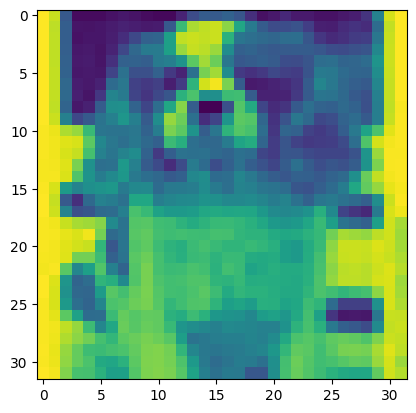

This is a bird:


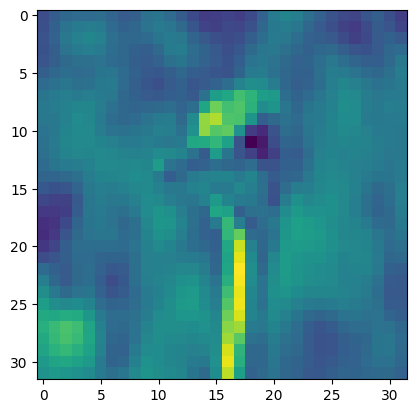

This is a bird:


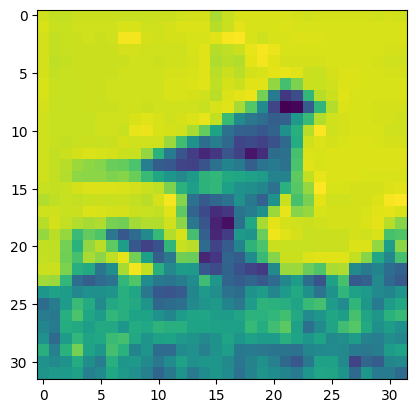

This is a ship:


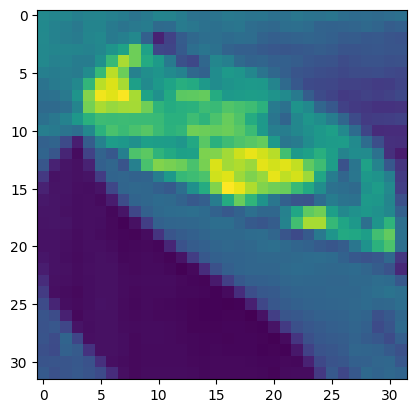

This is a airplane:


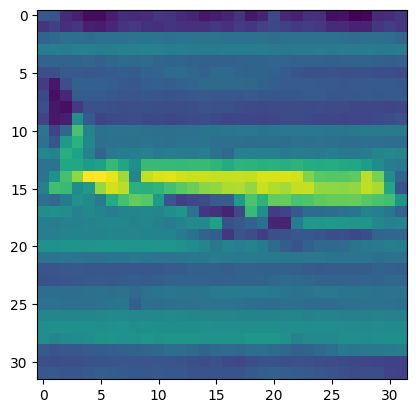

In [7]:
def check_data(n, data, random=True):
    indices = np.random.choice(trainset.data.shape[0], size=n)
    for i in indices:
        image, label = trainset[i]
        if label == 1:
            print('This is an {}:'.format(dataset_classes[label]))
        else:
            print('This is a {}:'.format(dataset_classes[label]))
        plt.figure()
        plt.imshow(image[0])
        plt.show()

# Examine data shape
print('Training data shape: {}'.format(trainset.data.shape))
print('Testing data shape: {}'.format(testset.data.shape))
check_data(5, trainset)

In [27]:
def test_model(model, device, test_loader, criterion, num_classes=10):
    model.eval()
    test_loss = 0
    correct = 0
    
    # Initialize arrays
    class_correct = torch.zeros(num_classes)
    class_total = torch.zeros(num_classes)
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            test_loss += criterion(outputs, labels).item()
            pred = outputs.argmax(dim=1)
            
            # Update overall accuracy counter
            correct += (pred == labels).sum().item()
            
            # Update per-class metrics more efficiently
            for c in range(num_classes):
                mask = (labels == c)
                class_total[c] += mask.sum().item()
                class_correct[c] += ((pred == labels) & mask).sum().item()
    
    # Calculate overall metrics
    total_samples = len(test_loader.dataset)
    test_loss /= total_samples
    accuracy = 100. * correct / total_samples
    
    # Calculate per-class metrics
    class_accuracies = []
    class_std_errors = []
    
    for c in range(num_classes):
        if class_total[c] > 0:
            p = class_correct[c] / class_total[c]
            acc = 100. * p
            # Binomial standard error
            stderr = 100. * math.sqrt(p * (1-p) / class_total[c].item())
        else:
            acc = stderr = 0
            
        class_accuracies.append(acc)
        class_std_errors.append(stderr)
    
    # results
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{total_samples} ({accuracy:.0f}%)')
    
    print('\nPer-class accuracies:')
    for c in range(num_classes):
        print(f'Class {c}: {class_accuracies[c]:.2f}% ± {class_std_errors[c]:.2f}%')
    
    valid_accuracies = [acc for acc, total in zip(class_accuracies, class_total) if total > 0]
    if valid_accuracies:
        print(f'\nAccuracy disparity: {max(valid_accuracies) - min(valid_accuracies):.2f}%')
    
    return test_loss, accuracy, class_accuracies, class_std_errors

In [10]:
#Train model
from transformers import AutoImageProcessor, AutoModelForImageClassification
train_loader = torch.utils.data.DataLoader(dataset = trainset,
                                           batch_size = 100,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = testset,
                                          batch_size = 100,
                                          shuffle = False)



import torch
import torch.nn as nn
import torch.nn.functional as F

##########################################
# ResNet architecture modified from:
# https://github.com/Taeyoung96/Resnet-from-scratch/blob/master/Resnet18-scratch-tutorial(CIFAR10).ipynb

class PreActBlock(nn.Module):
    """Pre-activation version of the BasicBlock"""
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)

        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out += shortcut
        return out

class PreActResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(PreActResNet, self).__init__()
        self.in_planes = 64
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.bn = nn.BatchNorm2d(512 * block.expansion)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.relu(self.bn(out))
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def PreActResNet18():
    return PreActResNet(PreActBlock, [2,2,2,2])

def train_natural(model, train_loader, device, num_epochs=15):
    """Natural training as described in paper Section 2"""
    model = model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            if batch_idx % 100 == 0:
                print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item():.4f}')
        
        scheduler.step()
        print(f'Epoch {epoch}: Average Loss = {total_loss/len(train_loader):.4f}')
    
    return model

model = PreActResNet18()

# Hyper-parameters
num_epochs = 15
learning_rate = 0.001

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Natural training
natural_model = train_natural(model, train_loader, device)
    
# Evaluate natural model
loss, acc, class_accs, class_stderrs = test_model(model, device, test_loader, criterion)

Epoch: 0, Batch: 0, Loss: 2.3312
Epoch: 0, Batch: 100, Loss: 1.8495
Epoch: 0, Batch: 200, Loss: 1.4394
Epoch: 0, Batch: 300, Loss: 1.2930
Epoch: 0, Batch: 400, Loss: 1.2574
Epoch 0: Average Loss = 1.5252
Epoch: 1, Batch: 0, Loss: 0.9994
Epoch: 1, Batch: 100, Loss: 1.1158
Epoch: 1, Batch: 200, Loss: 0.8669
Epoch: 1, Batch: 300, Loss: 0.7252
Epoch: 1, Batch: 400, Loss: 0.9357
Epoch 1: Average Loss = 0.9788
Epoch: 2, Batch: 0, Loss: 0.6581
Epoch: 2, Batch: 100, Loss: 0.8044
Epoch: 2, Batch: 200, Loss: 0.6450
Epoch: 2, Batch: 300, Loss: 0.7469
Epoch: 2, Batch: 400, Loss: 0.7367
Epoch 2: Average Loss = 0.7187
Epoch: 3, Batch: 0, Loss: 0.5545
Epoch: 3, Batch: 100, Loss: 0.7066
Epoch: 3, Batch: 200, Loss: 0.6181
Epoch: 3, Batch: 300, Loss: 0.5325
Epoch: 3, Batch: 400, Loss: 0.5200
Epoch 3: Average Loss = 0.5850
Epoch: 4, Batch: 0, Loss: 0.4902
Epoch: 4, Batch: 100, Loss: 0.4907
Epoch: 4, Batch: 200, Loss: 0.4307
Epoch: 4, Batch: 300, Loss: 0.4218
Epoch: 4, Batch: 400, Loss: 0.4857
Epoch 4: Av

In [12]:
#save model
import os

model_dir = os.path.join(dir_path, 'proj1_models')
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, 'natural_model.pt')
torch.save(natural_model.state_dict(), model_path)

In [28]:
#load natural model
natural_model_state = torch.load(dir_path + 'proj1_models/natural_model.pt')
natural_model = PreActResNet18()
natural_model.load_state_dict(natural_model_state)
natural_model.to(device)
loss, acc, class_accs, class_stderrs = test_model(natural_model, device, test_loader, criterion)


Test set: Average loss: 0.0039, Accuracy: 8909/10000 (89%)

Per-class accuracies:
Class 0: 90.60% ± 0.92%
Class 1: 95.00% ± 0.69%
Class 2: 82.00% ± 1.21%
Class 3: 77.80% ± 1.31%
Class 4: 90.60% ± 0.92%
Class 5: 81.80% ± 1.22%
Class 6: 93.10% ± 0.80%
Class 7: 91.90% ± 0.86%
Class 8: 93.80% ± 0.76%
Class 9: 94.30% ± 0.73%

Accuracy disparity: 17.20%


In [29]:
#standard errors for each class
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i, c in enumerate(classes):
    print(f"{c}: ±{class_stderrs[i]:.1f}%")

airplane: ±0.9%
automobile: ±0.7%
bird: ±1.2%
cat: ±1.3%
deer: ±0.9%
dog: ±1.2%
frog: ±0.8%
horse: ±0.9%
ship: ±0.8%
truck: ±0.7%
